In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

def process_hr_data():
    # 1. Chargement des données
    print("Chargement des fichiers...")
    general_data = pd.read_csv('data/general_data.csv')
    manager_survey = pd.read_csv('data/manager_survey_data.csv')
    employee_survey = pd.read_csv('data/employee_survey_data.csv')
    in_time = pd.read_csv('data/in_time.csv')
    out_time = pd.read_csv('data/out_time.csv')
    # 2. Fusion des données principales
    # On utilise EmployeeID comme clé de jointure
    df_main = general_data.merge(manager_survey, on='EmployeeID', how='left')
    df_main = df_main.merge(employee_survey, on='EmployeeID', how='left')

    # 3. Traitement des fichiers Temps (Badgeuse)
    # Renommer la première colonne vide ou index en 'EmployeeID'
    in_time.rename(columns={in_time.columns[0]: 'EmployeeID'}, inplace=True)
    out_time.rename(columns={out_time.columns[0]: 'EmployeeID'}, inplace=True)

    # Définir l'index pour faciliter les calculs matriciels
    in_time.set_index('EmployeeID', inplace=True)
    out_time.set_index('EmployeeID', inplace=True)

    print("Traitement des horaires (conversion et calcul)...")
    # Conversion en datetime (ignorer les erreurs pour les jours fériés/absences)
    processed_in = in_time.apply(pd.to_datetime, errors='coerce')
    processed_out = out_time.apply(pd.to_datetime, errors='coerce')

    # Calcul de la durée de travail journalière
    duration = processed_out - processed_in
    # Conversion en heures
    duration_hours = duration.apply(lambda x: x.dt.total_seconds() / 3600)

    # Création des nouvelles métriques
    # Moyenne des heures travaillées par jour (en ignorant les NaN/absences)
    mean_hours = duration_hours.mean(axis=1)
    # Nombre total de jours travaillés dans l'année
    working_days = duration_hours.count(axis=1)

    # Création du DataFrame des features temporelles
    time_features = pd.DataFrame({
        'EmployeeID': in_time.index,
        'AverageWorkingHours': mean_hours.values,
        'TotalWorkingDays': working_days.values
    })

    # 4. Fusion finale
    final_df = df_main.merge(time_features, on='EmployeeID', how='left')

    # 5. Nettoyage
    # Suppression des colonnes qui n'ont qu'une seule valeur (inutiles pour le modèle)
    # Exemple: 'Over18' est 'Y' pour tout le monde, 'StandardHours' est 8 pour tout le monde.
    nunique = final_df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    final_df.drop(columns=cols_to_drop, inplace=True)

    print(f"Colonnes supprimées (valeur constante) : {list(cols_to_drop)}")
    print(f"Taille finale du dataset : {final_df.shape}")

    # 6. Export
    final_df.to_csv('data/processed_hr_data.csv', index=False)
    print("Fichier 'processed_hr_data.csv' généré avec succès.")

    return final_df

# Exécution
if __name__ == "__main__":
    df = process_hr_data()
    print(df.head())

Chargement des fichiers...
Traitement des horaires (conversion et calcul)...
Colonnes supprimées (valeur constante) : ['EmployeeCount', 'Over18', 'StandardHours']
Taille finale du dataset : (4410, 28)
Fichier 'processed_hr_data.csv' généré avec succès.
   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeID  Gender  JobLevel  ... YearsAtCompany  \
0          2  Life Sciences           1  Female         1  ...              1   
1          1  Life Sciences           2  Female         1  ...              5   
2          4     

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Chargement des données
df = pd.read_csv('data/processed_hr_data.csv')

# 2. Nettoyage initial
if 'EmployeeID' in df.columns:
    df = df.drop(columns=['EmployeeID'])

# Remplissage des valeurs manquantes (uniquement sur les colonnes numériques)
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# 3. Traitement de la cible (Target)
if 'Attrition' in df.columns:
    df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# 4. Traitement des variables catégorielles

# A) Variable Ordinale (Ordre important) : BusinessTravel
# On map manuellement pour respecter la hiérarchie : Non < Rare < Frequent
travel_map = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
if 'BusinessTravel' in df.columns:
    df['BusinessTravel'] = df['BusinessTravel'].map(travel_map)

# B) Variables Nominales (Pas d'ordre) : One-Hot Encoding
# Cela va créer des colonnes comme 'Department_Sales', 'Department_HR', etc.
nominal_cols = ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
# On vérifie que les colonnes existent bien
nominal_cols = [c for c in nominal_cols if c in df.columns]

# On applique le One-Hot Encoding (pd.get_dummies)
df_encoded = pd.get_dummies(df, columns=nominal_cols)
# On convertit tout en nombres (0.0 / 1.0) pour être sûr
df_encoded = df_encoded.astype(float)

# --- GÉNÉRATION DES DEUX FICHIERS ---

# FICHIER 1 : Non Normalisé (Brut mais encodé)
# Utile pour Random Forest, XGBoost, interprétation métier.
# Les salaires restent à 50000, l'âge à 30, etc.
df_not_normalized = df_encoded.copy()
df_not_normalized.to_csv('data/processed_hr_data_encoded_raw.csv', index=False)

# FICHIER 2 : Normalisé (0-1)
# Utile pour Réseaux de Neurones, KNN, Régression Logistique.
# Toutes les valeurs sont ramenées entre 0 et 1.
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
df_normalized.to_csv('data/processed_hr_data_encoded_normalized.csv', index=False)

print("Traitement terminé.")
print(f"Colonnes générées ({len(df_encoded.columns)}) :")
print(df_encoded.columns.tolist())

Traitement terminé.
Colonnes générées (45) :
['Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'AverageWorkingHours', 'TotalWorkingDays', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executi

--- STATISTIQUES DES DONNÉES (HORS 0/1) ---
                                 mean        median           min  \
Age                         36.923810     36.000000     18.000000   
BusinessTravel               1.086395      1.000000      0.000000   
DistanceFromHome             9.192517      7.000000      1.000000   
Education                    2.912925      3.000000      1.000000   
JobLevel                     2.063946      2.000000      1.000000   
MonthlyIncome            65029.312925  49190.000000  10090.000000   
NumCompaniesWorked           2.694830      2.000000      0.000000   
PercentSalaryHike           15.209524     14.000000     11.000000   
StockOptionLevel             0.793878      1.000000      0.000000   
TotalWorkingYears           11.279936     10.000000      0.000000   
TrainingTimesLastYear        2.799320      3.000000      0.000000   
YearsAtCompany               7.008163      5.000000      0.000000   
YearsSinceLastPromotion      2.187755      1.000000      0.

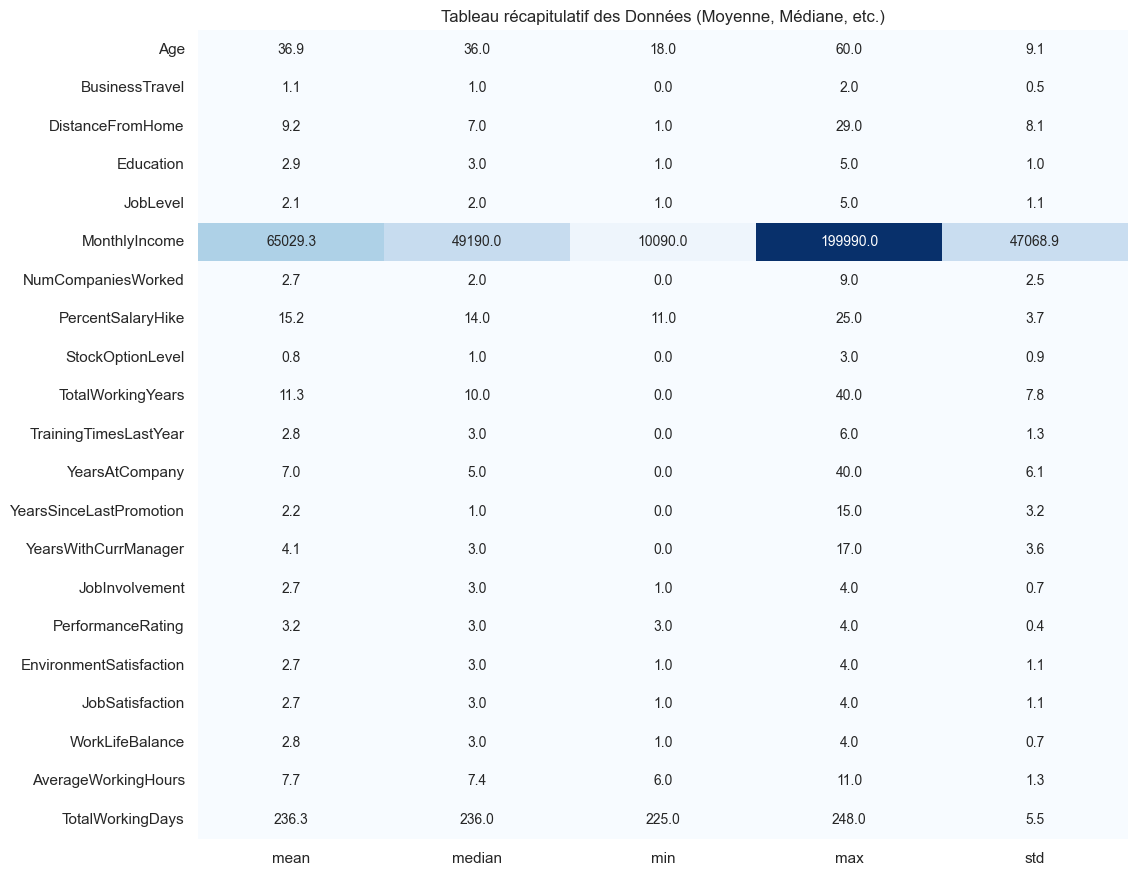

C:\Users\Fire\AppData\Local\Temp\ipykernel_4704\1339108423.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Attrition_Label', data=df, palette='viridis', order=['No', 'Yes'])


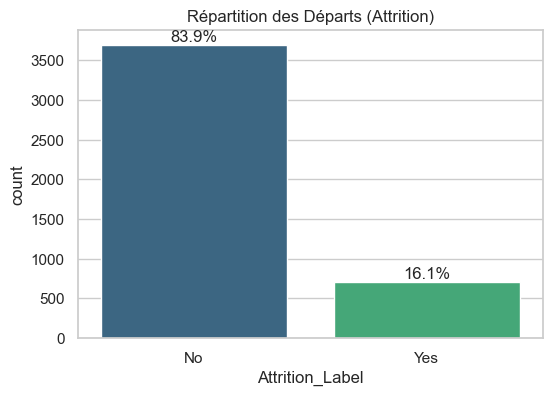

C:\Users\Fire\AppData\Local\Temp\ipykernel_4704\1339108423.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=role_attrition.index, y=role_attrition.values, palette='magma')


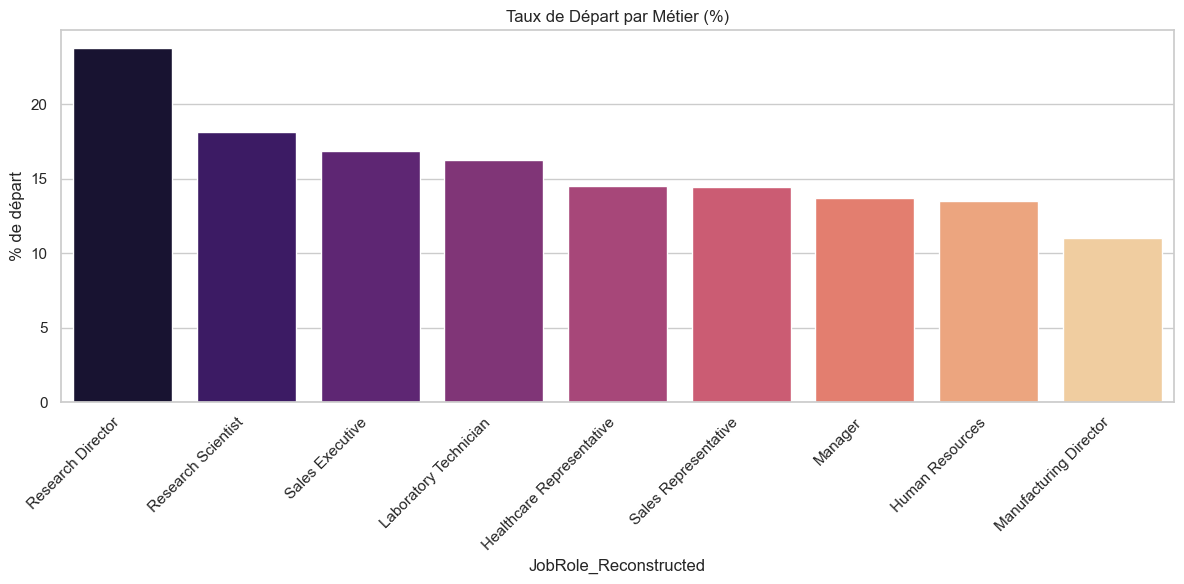

C:\Users\Fire\AppData\Local\Temp\ipykernel_4704\1339108423.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition_Label', y='AverageWorkingHours', data=df, palette='coolwarm', order=['No', 'Yes'])


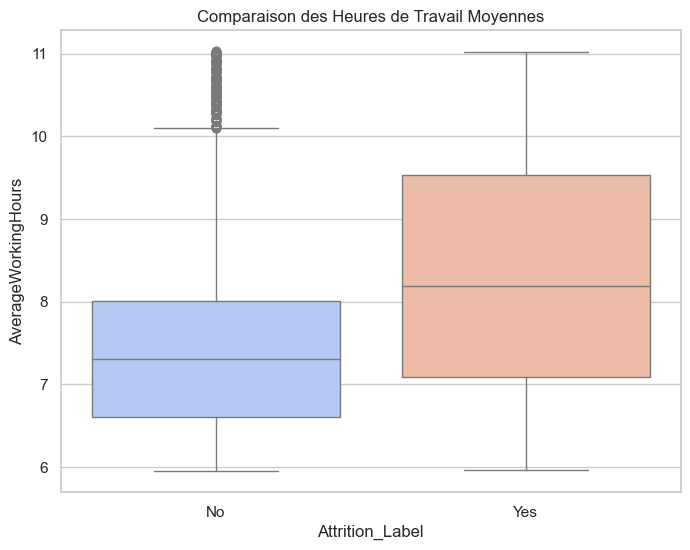

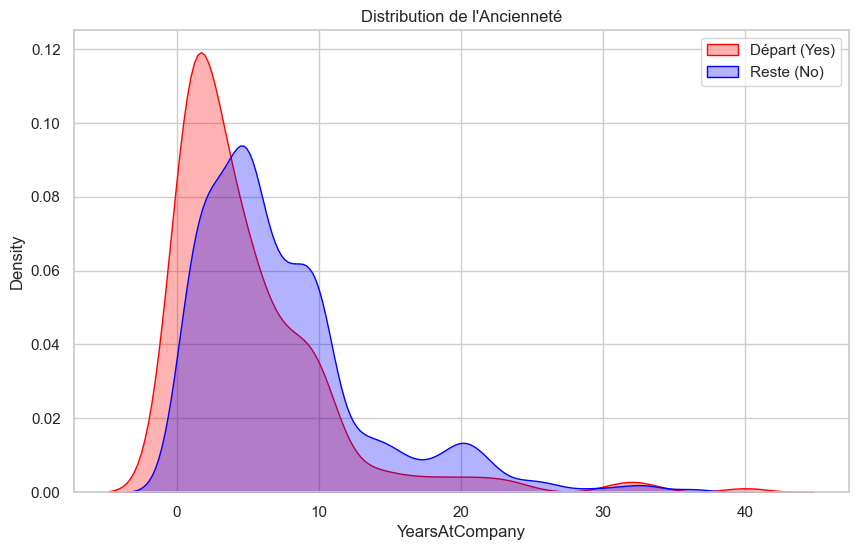

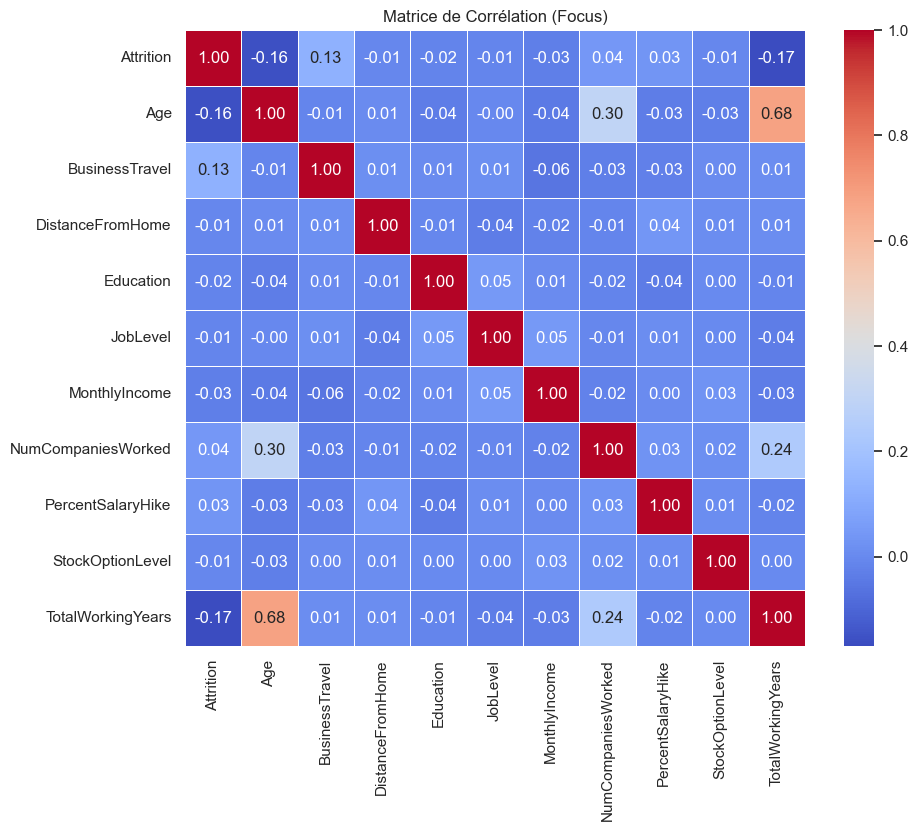

In [8]:
def analyze_and_show():
    # 1. Chargement des données encodées (mais non normalisées)
    df = pd.read_csv('data/processed_hr_data_encoded_raw.csv')
    
    # --- PRÉPARATION POUR L'AFFICHAGE ---
    # Recréation des labels pour la lisibilité
    df['Attrition_Label'] = df['Attrition'].map({0: 'No', 1: 'Yes'})
    
    # Reconstruction de JobRole pour les graphes
    job_role_cols = [c for c in df.columns if c.startswith('JobRole_')]
    if job_role_cols:
        df['JobRole_Reconstructed'] = df[job_role_cols].idxmax(axis=1).str.replace('JobRole_', '')

    # Configuration du style
    sns.set(style="whitegrid")

    # ==============================================================================
    # NOUVEAU : TABLEAU DE STATISTIQUES (SAUF BINAIRES 0/1)
    # ==============================================================================
    print("--- STATISTIQUES DES DONNÉES (HORS 0/1) ---")
    
    # On identifie les colonnes qui ne sont PAS binaires
    non_binary_cols = []
    for col in df.select_dtypes(include=['number']).columns:
        unique_vals = set(df[col].dropna().unique())
        if not unique_vals.issubset({0, 1}):
            non_binary_cols.append(col)
    
    # Calcul des stats : count, mean, std, min, 25%, 50% (mediane), 75%, max
    stats_df = df[non_binary_cols].describe().T
    stats_df['median'] = df[non_binary_cols].median()
    
    # Sélection des colonnes les plus pertinentes pour l'affichage
    display_cols = ['mean', 'median', 'min', 'max', 'std']
    print(stats_df[display_cols])
    
    # Petit graphique bonus pour visualiser ces stats (table graphique)
    plt.figure(figsize=(12, len(non_binary_cols)/2))
    
    # CORRECTION ICI : On passe stats_df[display_cols] comme données ET comme annotations
    sns.heatmap(stats_df[display_cols], annot=True, fmt=".1f", 
                cmap="Blues", cbar=False, annot_kws={"size": 10})
                
    plt.title("Tableau récapitulatif des Données (Moyenne, Médiane, etc.)")
    plt.show()
    # ==============================================================================

    
    # --- GRAPHIQUE 1 : Distribution Globale ---
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x='Attrition_Label', data=df, palette='viridis', order=['No', 'Yes'])
    plt.title('Répartition des Départs (Attrition)')
    
    total = len(df)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')
    plt.show()

    # --- GRAPHIQUE 2 : Départ par Métier ---
    if 'JobRole_Reconstructed' in df.columns:
        role_attrition = df.groupby('JobRole_Reconstructed')['Attrition'].mean() * 100
        role_attrition = role_attrition.sort_values(ascending=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=role_attrition.index, y=role_attrition.values, palette='magma')
        plt.xticks(rotation=45, ha='right')
        plt.title('Taux de Départ par Métier (%)')
        plt.ylabel('% de départ')
        plt.tight_layout()
        plt.show()

    # --- GRAPHIQUE 3 : Heures de Travail ---
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Attrition_Label', y='AverageWorkingHours', data=df, palette='coolwarm', order=['No', 'Yes'])
    plt.title('Comparaison des Heures de Travail Moyennes')
    plt.show()

    # --- GRAPHIQUE 4 : Ancienneté ---
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df[df['Attrition'] == 1]['YearsAtCompany'], label='Départ (Yes)', fill=True, color='red', alpha=0.3)
    sns.kdeplot(data=df[df['Attrition'] == 0]['YearsAtCompany'], label='Reste (No)', fill=True, color='blue', alpha=0.3)
    plt.title("Distribution de l'Ancienneté")
    plt.legend()
    plt.show()

    # --- GRAPHIQUE 5 : Matrice de Corrélation ---
    cols_corr = ['Attrition'] + [c for c in non_binary_cols if c in df.columns][:10]
    
    plt.figure(figsize=(10, 8))
    corr = df[cols_corr].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Matrice de Corrélation (Focus)')
    plt.show()

if __name__ == "__main__":
    analyze_and_show()